# Data import & data processing

<!DOCTYPE html>
<html>
<head>
    <title>Project Progress</title>
</head>
<body>
    <h1>Project Progress Overview</h1>
    <ul>
        <li><strong>Data Collection</strong>: A European index from 1998 to 2023, inflation, output gap, and main refinancing rate in Europe [?]</li>
        <li><strong>Scrapping and Data Cleaning and Consolidation</strong> [Done]</li>
        <li><strong>Calculating the Jaccard Similarity</strong> [Done] - Assigned to Gwen for improvement</li>
        <li><strong>Calculating the Pessimism Score for Every Period</strong> [Done]</li>
        <li><strong>Pessimism Score Improvement Using Hugo's Algorithm</strong> - Assigned to Hugo</li>
        <li><strong>Final DataFrame Construction</strong> - Assigned to Charaf</li>
        <li><strong>Calculating the Cumulative Abnormal Returns for the European Index</strong> - Assigned to Gwen</li>
        <li><strong>Regressing the Cumulative Abnormal Returns on Combinations of Pessimism Scores, Similarity, Inflation, Output Gap, and Main Refinancing Rates</strong> - Is this done? If not, assigned to Gwen</li>
        <li><strong>Analysing Non-Linearity in Cumulative Abnormal Returns</strong></li>
        <li><strong>Report Writing</strong></li>
        <li><strong>Preparing Slides for Presentation</strong></li>
    </ul>
</body>
</html>


In [29]:

import pandas as pd
import re
import numpy as np
import os
import time
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem.porter import PorterStemmer
import itertools
import matplotlib.pyplot as plt



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zgcha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Web scrapping

from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time

# Set up the WebDriver
driver_path = '/path/to/your/webdriver'  # Replace with the path to your WebDriver
driver = webdriver.Chrome(executable_path=driver_path)

# The target URL
url = 'https://www.ecb.europa.eu/press/pressconf/html/index.en.html'

# Open the page with Selenium
driver.get(url)

# Let the page load (wait for a few seconds if needed)
time.sleep(3)

# Get the page source and parse it with BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

# Find all <dt> and <dd> tags which contain the date and the link respectively
dates = soup.find_all('dt', {'isodate': True})
statements = soup.find_all('dd')

# Initialize an empty list to store the data
data = []

# Iterate over the dates and statements
for date, statement in zip(dates, statements):
    # Extract date
    statement_date = date.div.text.strip()

    # Extract the link
    link_tag = statement.find('a')
    if link_tag and 'href' in link_tag.attrs:
        statement_url = 'https://www.ecb.europa.eu' + link_tag['href']

        # Use Selenium to open the statement page
        driver.get(statement_url)
        time.sleep(3)  # Wait for the page to load

        # Parse the opened page
        statement_soup = BeautifulSoup(driver.page_source, 'html.parser')
        # Extract content from the <main> tag
        statement_content = statement_soup.find('main').text.strip() if statement_soup.find('main') else ''

        # Append the data to the list
        data.append({
            'date': statement_date,
            'link': statement_url,
            'content': statement_content
        })

# Close the WebDriver
driver.quit()

# Create a DataFrame
df = pd.DataFrame(data)

# Now df contains the desired data
df.to_csv('final_df.csv')


In [113]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd

# Presuming ecb_statements is a DataFrame with a column 'link' containing URLs

# Set up the WebDriver
driver = webdriver.Chrome()

try:
    # Initialize an empty list to store the data
    data = []

    # Iterate over URLs from the DataFrame
    for index, row in ecb_statements.iterrows():
        url = row['link']
        driver.get(url)
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'main')))
        
        statement_soup = BeautifulSoup(driver.page_source, 'html.parser')

        # Extract content
        statement_content = statement_soup.find('main').text.strip() if statement_soup.find('main') else ''

        # Append the data to the list
        data.append({
            'date': row['date'],  # Assuming the date is already in ecb_statements
            'link': url,
            'content': statement_content
        })

finally:
    # Close the WebDriver
    driver.quit()

# Create a DataFrame and export if needed
df = pd.DataFrame(data)
# df.to_csv('ecb_statements_with_content.csv')


In [114]:
df

,date,link,content
0,2023-10-26,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...
1,2023-09-14,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...
2,2023-07-27,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...
3,2023-05-23,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...
4,2023-05-04,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...
...,...,...,...
270,1998-11-03,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...
271,1998-10-13,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...
272,1998-09-01,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...
273,1998-07-08,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...


In [98]:
dates

[<dt isodate="2023-12-14"><div class="date">14 December 2023</div></dt>,
 <dt isodate="2023-10-26"><div class="date">26 October 2023</div></dt>,
 <dt isodate="2023-09-14"><div class="date">14 September 2023</div></dt>,
 <dt isodate="2023-07-27"><div class="date">27 July 2023</div></dt>,
 <dt isodate="2023-06-15"><div class="date">15 June 2023</div></dt>,
 <dt isodate="2023-05-04"><div class="date">4 May 2023</div></dt>,
 <dt isodate="2023-03-16"><div class="date">16 March 2023</div></dt>,
 <dt isodate="2023-02-02"><div class="date">2 February 2023</div></dt>]

In [97]:
statements

[<dd><div class="title"><a href="/press/pressconf/2023/html/ecb.is231214~df8627de60.en.html">Christine Lagarde, Luis de Guindos: Monetary policy statement (with Q&amp;A)</a></div><div class="subtitle">Christine Lagarde,  President of the ECB,  Luis de Guindos,  Vice-President of the ECB,  Frankfurt am Main,  14 December 2023</div><div class="ecb-langSelector"><span class="offeredLanguage"><a class="arrow" href="/press/pressconf/2023/html/ecb.is231214~df8627de60.en.html" lang="en">
 <span class="ecb-full">English</span></a></span><div class="moreLanguages">
 <span class="lnglabel">OTHER LANGUAGES</span>
 <span class="lang-counter">(23)</span>
 <span class="ecb-plus">+</span>
 </div>
 <div class="ecb-langPopup">
 <div class="ecb-closeBtn"></div>
 <div class="ecb-langHead">Select your language</div>
 <div class="otherlang"><a href="/press/pressconf/2023/html/ecb.is231214~df8627de60.bg.html" lang="bg">
 <span class="ecb-full">Български</span><span class="ecb-short">BG</span></a><a href="/p

# Data processing

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
ecb_statements = pd.read_csv('final_df.csv').drop('Date',axis=1)

#ecb_statements['date'] = pd.to_datetime(ecb_statements['date'], format='%d %B %Y')

# The 'date' column will now be in the numeric date format (yyyy-mm-dd)
# Display the DataFrame to verify
ecb_statements.head()
df_conf=ecb_statements
df_conf
df_conf['date']=pd.to_datetime(df_conf['date'],format='%Y-%m-%d')

In [109]:
ecb_statements.link

0      https://www.ecb.europa.eu/press/pressconf/2023...
1      https://www.ecb.europa.eu/press/pressconf/2023...
2      https://www.ecb.europa.eu/press/pressconf/2023...
3      https://www.ecb.europa.eu/press/pressconf/2023...
4      https://www.ecb.europa.eu/press/pressconf/2023...
                             ...                        
270    https://www.ecb.europa.eu/press/pressconf/1998...
271    https://www.ecb.europa.eu/press/pressconf/1998...
272    https://www.ecb.europa.eu/press/pressconf/1998...
273    https://www.ecb.europa.eu/press/pressconf/1998...
274    https://www.ecb.europa.eu/press/pressconf/1998...
Name: link, Length: 275, dtype: object

In [47]:
df_conf

,Unnamed: 0,link,content,date
0,0,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-10-26
1,1,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-09-14
2,2,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-07-27
3,3,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-05-23
4,4,https://www.ecb.europa.eu/press/pressconf/2023...,MONETARY POLICY STATEMENTPRESS CONFERENCEChris...,2023-05-04
...,...,...,...,...
270,270,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-11-03
271,271,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-10-13
272,272,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-09-01
273,273,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,1998-07-08


In [138]:
df.to_csv('yet_another_final_df.csv')

In [139]:
df_conf=df

In [119]:
df_.iloc[20]['content']

"INTRODUCTORY STATEMENT\n\nPRESS CONFERENCE\n\n\nChristine Lagarde, President of the ECB,Luis de Guindos, Vice-President of the ECB \nFrankfurt am Main, 10 June 2021\nJump to the transcript of the questions and answers\nLadies and gentlemen, the Vice-President and I are very pleased to welcome you to our press conference. We will now report on the outcome of the meeting of the Governing Council, which was also attended by the Commission Executive Vice-President, Mr Dombrovskis.\nAfter the contraction in the first quarter of the year, the euro area economy is gradually reopening as the pandemic situation improves and vaccination campaigns make significant progress. The latest data signal a bounce-back in services activity and ongoing dynamism in manufacturing production. We expect economic activity to accelerate in the second half of this year as further containment measures are lifted. A pick-up in consumer spending, strong global demand and accommodative fiscal and monetary policies w

In [230]:
df_conf.content[190]

'Ladies and gentlemen, it is our pleasure to welcome you to this press conference. The Vice-President and I will now report on the outcome of today’s meeting of the Governing Council of the ECB.\nAll in all, the information which has become available since the last meeting of the Governing Council means that our assessment of price stability over the medium term is unchanged. While short-term HICP inflation rates remain subject to certain volatilities, particularly in relation to oil prices, there is no significant evidence of underlying domestic inflationary pressures building up in the euro area. Accordingly, we have left the key ECB interest rates unchanged at their historically low levels. However, upside risks to price stability over the medium term remain. Continued vigilance is therefore of the essence with regard to those risks. \nI shall now explain our assessment in more detail. \nTurning first to the economic analysis, recent data on economic activity, as well as survey info

In [140]:
df_conf=df_conf.drop('Unnamed: 0',axis=1)

KeyError: "['Unnamed: 0'] not found in axis"

 # Content cleaning
 

In [141]:
# Assuming df_conf is your DataFrame

# 1. Remove "Jump to the transcript" phrases
df_conf['content'] = df_conf['content'].str.replace("Jump to the transcript", "", regex=False)

# 2. Apply the text_cleansing function to each row in the 'content' column
def text_cleansing(text):
    index = text.find("answers")
    if index != -1:
        text_cleaned = text[index + len("answers"):].strip()
        split_phrases = [
            "We are now ready to take your questions.",
            "We are now at your disposal for questions.",
            "We are now at your disposal, should you have any questions.",
            "Transcript of the questions asked and the answers given by",
            "We stand ready to answer any questions you may have.",
            "CONTACT",
            "You may also be interested",
            "Related topics"
        ]
        for phrase in split_phrases:
            text_cleaned = text_cleaned.split(phrase)[0]
        return text_cleaned
    else:
        return text

df_conf['content'] = df_conf['content'].apply(text_cleansing)

# 3. Set the 'date' column as the index of the DataFrame
df_conf = df_conf.set_index('date')

# Additional operation (if required):
# Drop an entry without text content (if applicable)
# df_conf = df_conf.drop(index=[index_of_unnecessary_entry])


In [142]:

stops = list(stopwords.words('english'))


def clean(x):
    x = x.lower()
    x = re.sub(r'[^\w\s]', '', x)
    x = word_tokenize(x)
    x = [w for w in x if w not in stops]
    return(x)

df_conf['transform'] = [clean(i) for i in (df_conf['content'])]

stemmer = PorterStemmer()
df_conf['stem'] = df_conf['transform'].apply(lambda x: [stemmer.stem(token) for token in x])
df_conf

,link,content,transform,stem
date,,,,
2023-10-26,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-09-14,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-07-27,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-23,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
2023-05-04,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c..."
...,...,...,...,...
1998-11-03,https://www.ecb.europa.eu/press/pressconf/1998...,". \nLadies and gentlemen, as in previous month...","[ladies, gentlemen, previous, months, vicepres...","[ladi, gentlemen, previou, month, vicepresid, ..."
1998-10-13,https://www.ecb.europa.eu/press/pressconf/1998...,".\nLadies and gentlemen, in line with our stat...","[ladies, gentlemen, line, stated, intention, v...","[ladi, gentlemen, line, state, intent, vicepre..."
1998-09-01,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ..."


In [61]:
df_conf.sort_values(by='date').iloc[189]

link                  https://www.ecb.europa.eu/press/pressconf/2013...
content               Ladies and gentlemen, I am very pleased to wel...
transform             [ladies, gentlemen, pleased, welcome, press, c...
stem                  [ladi, gentlemen, pleas, welcom, press, confer...
jaccard_similarity                                             0.476082
Name: 2013-12-05 00:00:00, dtype: object

In [143]:
df_conf=df_conf.sort_values(by='date')

# SIMILARITY MEASURE

In [144]:
import pandas as pd
import numpy as np
from itertools import tee, islice

def jaccard_similarity(set_1, set_2):
    intersection = set_1.intersection(set_2)
    union = set_1.union(set_2)
    return len(intersection) / len(union) if len(union) > 0 else 0

def find_bigrams(input_list):
    a, b = tee(input_list)
    next(b, None)
    return set(zip(a, b))

jaccard_similarities = [np.nan]  # 

# Iterate over the DataFrame and calculate Jaccard similarity for bigrams of successive speeches
for i in range(1, len(df_conf['stem'])):
    bigrams_i = find_bigrams(df_conf['stem'].iloc[i])
    bigrams_i_1 = find_bigrams(df_conf['stem'].iloc[i - 1])
    similarity = jaccard_similarity(bigrams_i, bigrams_i_1)
    jaccard_similarities.append(similarity)

# Add the similarity scores to the DataFrame
df_conf['jaccard_similarity'] = jaccard_similarities


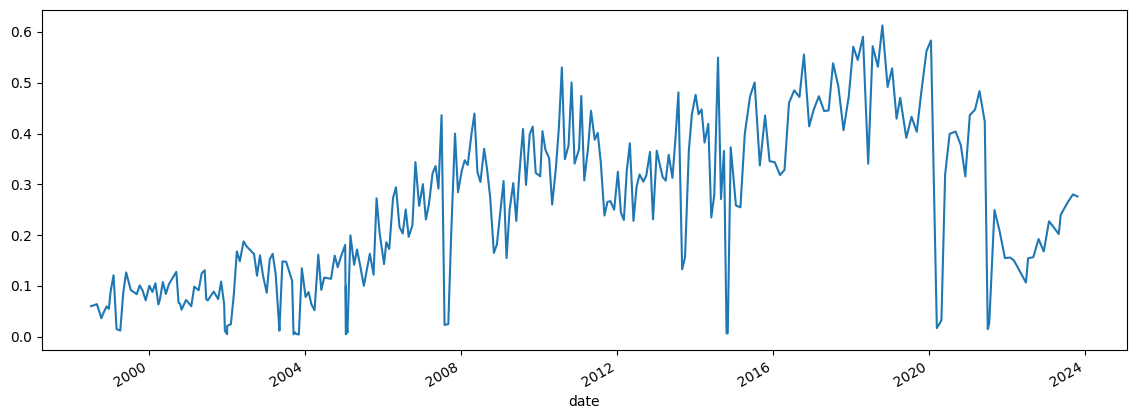

In [145]:
plt.figure(figsize=(14,5))
df_conf.jaccard_similarity.plot()
plt.show()

In [147]:
df_conf.to_csv('yet_another_final_df.csv')

In [72]:
df_conf.to_csv('output_2.csv')

In [74]:
df_conf.iloc[9]['content']

'given by Dr. Willem F. Duisenberg, President of the ECB, and Christian Noyer, Vice-President of the ECB\n\n\n\nQuestion (translation): Mr. President, what, in your view, are the reasons for the weak euro? Is it due to the interest rate and business activity differentials vis-à-vis the United States, as is argued by some, or is it rather due to the political pressure brought to bear on the central bank, as argue others?\nDuisenberg: We think it is predominantly the strength of the US dollar, rather than the weakness of the euro, which is determining the picture. And, of course, the interest rate differentials may also have something to do with that. We think those are the main factors explaining the recent decline in the value of the euro, which - if you look at the level which the euro has now reached - I would like to add is more or less the level which the D-Mark had during most of last year, and the strength with which the euro started life was more the exception than the rule. \nQ

# Pessimism Score


In [20]:
# Assuming df_conf is your DataFrame
df_conf = df_conf[:-1]  # This will exclude the last row from the DataFrame


In [53]:
df_conf

,Unnamed: 0,link,content,transform,stem,jaccard_similarity,pessimism,pessimism_2
date,,,,,,,,
1998-06-09,274.0,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",NaN,NaN,NaN
1998-07-08,273.0,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",0.060071,NaN,NaN
1998-09-01,272.0,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",0.064062,NaN,NaN
1998-10-13,271.0,https://www.ecb.europa.eu/press/pressconf/1998...,".\nLadies and gentlemen, in line with our stat...","[ladies, gentlemen, line, stated, intention, v...","[ladi, gentlemen, line, state, intent, vicepre...",0.036315,NaN,NaN
1998-11-03,270.0,https://www.ecb.europa.eu/press/pressconf/1998...,". \nLadies and gentlemen, as in previous month...","[ladies, gentlemen, previous, months, vicepres...","[ladi, gentlemen, previou, month, vicepresid, ...",0.047558,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-05-23,3.0,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.240066,NaN,NaN
2023-07-27,2.0,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.264469,NaN,NaN
2023-09-14,1.0,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.280069,NaN,NaN


In [59]:
df_conf

,link,content,transform,stem,jaccard_similarity
date,,,,,
1998-06-09,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",NaN
1998-07-08,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",0.060071
1998-09-01,https://www.ecb.europa.eu/press/pressconf/1998...,ECB Press conference: Introductory statement\n...,"[ecb, press, conference, introductory, stateme...","[ecb, press, confer, introductori, statement, ...",0.064062
1998-10-13,https://www.ecb.europa.eu/press/pressconf/1998...,".\nLadies and gentlemen, in line with our stat...","[ladies, gentlemen, line, stated, intention, v...","[ladi, gentlemen, line, state, intent, vicepre...",0.036315
1998-11-03,https://www.ecb.europa.eu/press/pressconf/1998...,". \nLadies and gentlemen, as in previous month...","[ladies, gentlemen, previous, months, vicepres...","[ladi, gentlemen, previou, month, vicepresid, ...",0.047558
...,...,...,...,...,...
2023-05-04,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.202136
2023-05-23,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.240066
2023-07-27,https://www.ecb.europa.eu/press/pressconf/2023...,"Good afternoon, the Vice-President and I welco...","[good, afternoon, vicepresident, welcome, pres...","[good, afternoon, vicepresid, welcom, press, c...",0.264469


In [24]:
df_conf=df_conf.drop('Unnamed: 0',axis=1)

In [60]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Assuming df_conf is your DataFrame
# Add two new columns for pessimism scores
df_conf['pessimism'] = np.NaN
df_conf['pessimism_2'] = np.NaN

# Load the Loughran-McDonald sentiment word lists
lm = pd.read_csv('Loughran-McDonald_MasterDictionary_1993-2021.csv')
neg_list = set(lm[lm["Negative"] != 0]["Word"].str.lower())
pos_list = set(lm[lm["Positive"] != 0]["Word"].str.lower())

# Function to calculate pessimism
def calculate_pessimism(row):
    neg_words = [token for token in row['transform'] if token in neg_list]
    pos_words = [token for token in row['transform'] if token in pos_list]
    
    neg_count = len(neg_words)
    pos_count = len(pos_words)
    total_words = len(row['transform'])

    # Avoid division by zero
    if total_words == 0:
        return np.NaN, np.NaN

    pessimism_score = (neg_count - pos_count) / (neg_count + pos_count + 1e-10)
    pessimism_score_2 = (neg_count - pos_count) / total_words

    return pessimism_score, pessimism_score_2

# Apply the function to the DataFrame
pessimism_scores = df_conf.apply(calculate_pessimism, axis=1)
df_conf['pessimism'] = [score[0] for score in pessimism_scores]
df_conf['pessimism_2'] = [score[1] for score in pessimism_scores]


In [66]:
df_conf=df_conf.reset_index()

In [67]:
df_conf=df_conf.reset_index()

# Plotting


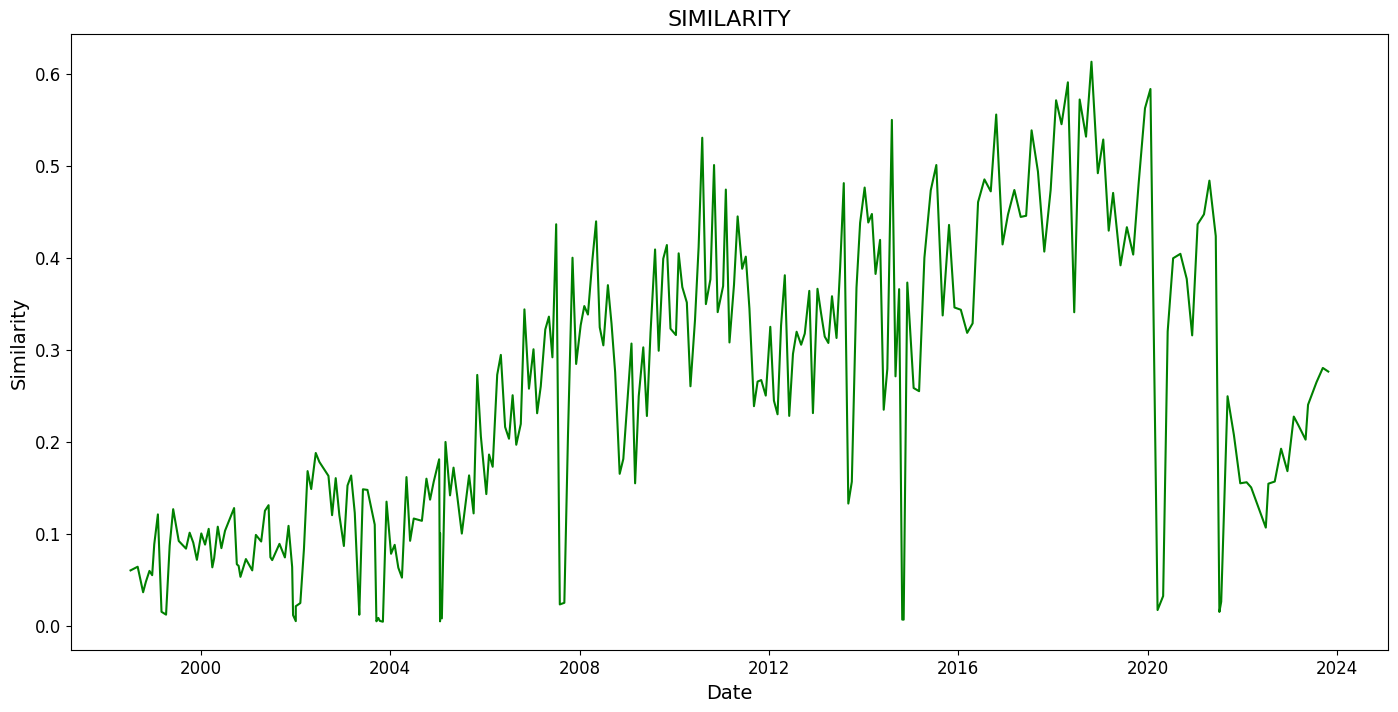

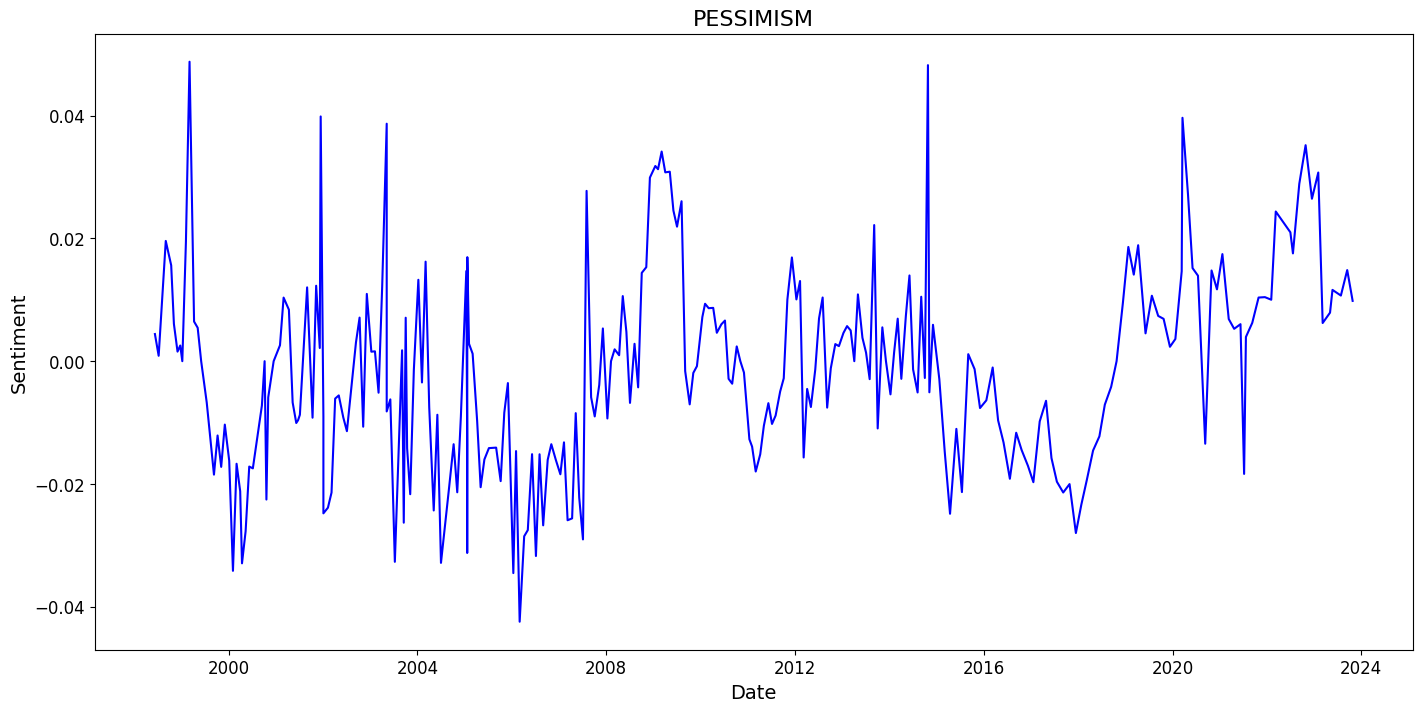

In [67]:
# plotting function to be applied to every measure
df_conf.rename(columns={'date': 'Date'}, inplace=True)
def plot_result(df, x, y, title, xlabel, ylabel, color):
    # Create a figure and set the size
    plt.figure(figsize=(17, 8))

    # Plot the specified columns using the specified color
    plt.plot(df[x], df[y], color=color)

    # Add a title and axis labels
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.grid()

    # Show the plot
    plt.show()


# Convert 'date' column to datetime format in date_2 just for visualisation
df_conf['date_2'] = pd.to_datetime(df_conf['Date'])


#plot  similarity
plot_result(df_conf, 'date_2', 'jaccard_similarity', 'SIMILARITY', 'Date', 'Similarity', 'green')
# plot sentiment_2 which the one used in the paper
plot_result(df_conf, 'date_2', 'pessimism_2', 'PESSIMISM', 'Date', 'Sentiment', 'blue')
#plot pessimism 1
#plot_result(df_conf, 'date_2', 'pessimism', 'PESSIMISM', 'Date', 'Sentiment', 'teal')


In [68]:
from datetime import datetime

def days_since_1999(date):
    start_date = datetime(1998, 6, 9)
    end_date = date
    return (end_date - start_date).days


dt = [days_since_1999(i) for i in df_conf['date_2']]
df_conf['diff'] = dt


reg_df = df_conf[['Date', 'jaccard_similarity', 'pessimism', 'pessimism_2', 'diff']]
reg_df = reg_df.rename(columns={'date': 'Date'})

reg_df

,Date,jaccard_similarity,pessimism,pessimism_2,diff
0,1998-06-09,NaN,1.000000,0.004425,0
1,1998-07-08,0.060071,0.040000,0.000881,29
2,1998-09-01,0.064062,0.531915,0.019592,84
3,1998-10-13,0.036315,0.294798,0.015620,126
4,1998-11-03,0.047558,0.169811,0.006073,147
...,...,...,...,...,...
270,2023-05-04,0.202136,0.148936,0.007910,9095
271,2023-05-23,0.240066,0.214286,0.011617,9114
272,2023-07-27,0.264469,0.227273,0.010695,9179
273,2023-09-14,0.280069,0.291667,0.014846,9228


In [143]:
df_eurostock = pd.read_excel('MSCI EURO.xlsx')[['Date','Price']].sort_values(by='Date')
df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')
df_eurostock['last'] = list(map(lambda x: np.log(x), df_eurostock['Price']))
df_eurostock['pct_change'] = np.NaN
df_eurostock['pct_change'] = df_eurostock['last'].diff(1)

In [144]:
df_eurostock.tail(40)
df_eurostock.dropna(inplace=True)
df_eurostock_to_np = df_eurostock['pct_change'].to_numpy()
df_eurostock

,Date,Price,last,pct_change
7011,1997-01-01,549.766000,6.309493,0.000000
7010,1997-01-02,540.659000,6.292789,-0.016704
7009,1997-01-03,545.842000,6.302330,0.009541
7008,1997-01-06,549.316000,6.308674,0.006344
7007,1997-01-07,549.231000,6.308519,-0.000155
...,...,...,...,...
4,2023-11-10,1371.655134,7.223773,-0.007365
3,2023-11-13,1381.763593,7.231116,0.007343
2,2023-11-14,1402.400629,7.245941,0.014825
1,2023-11-15,1409.783286,7.251191,0.005250


# GETTING EUROSTOCK DATA

In [145]:
#%%******************************************************



window_value_abnormal_return = {}
window_value_car = {}

df_eurostock['cumulate'] = np.NaN
df_eurostock['CAR'] = np.NaN

 
for n in (range(len(df_eurostock_to_np))):
    x = df_eurostock_to_np[n-251:n-50]
    window_value_abnormal_return[n] = 1/201*(np.sum(x))
liste_cumu = list(window_value_abnormal_return.values())
df_eurostock.cumulate = liste_cumu
df_eurostock['abnormal_return'] = np.NaN

 
df_eurostock['abnormal_return'] = df_eurostock['pct_change'] - df_eurostock['cumulate']
df_eurostock_car_to_np = df_eurostock['abnormal_return'].to_numpy()

#  Computation of cumulative abnormal returns via the same method used above
for n in (range(len(df_eurostock_car_to_np))):
    x = df_eurostock_car_to_np[n-6:n+5]
    window_value_car[n] = np.sum(x)
liste_car= list(window_value_car.values())
df_eurostock.CAR = liste_car

df_eurostock['Date'] = df_eurostock['Date'].astype('datetime64[ns]')
df_eurostock.rename(columns = {'last':'eurostock_last','pct_change':'eurostock_pct_change','cumulate':'eurostock_cumulate',
                               'abnormal_return':'eurostock_abnormal_return', 'CAR':'eurostock_CAR'}, inplace = True)

df_eurostock['Date'] = pd.to_datetime(df_eurostock['Date'], format='%d/%m/%Y')

# retrieving Eurostock CAR results in a new df
df_eurostock_final = df_eurostock.loc[:,['Date', 'eurostock_cumulate', 'eurostock_abnormal_return', 'eurostock_CAR']]
df_eurostock_final

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR
7011,1997-01-01,0.000309,-0.000309,0.000000
7010,1997-01-02,0.000297,-0.017001,0.000000
7009,1997-01-03,0.000323,0.009218,0.000000
7008,1997-01-06,0.000333,0.006011,0.000000
7007,1997-01-07,0.000338,-0.000493,0.000000
...,...,...,...,...
4,2023-11-10,0.000421,-0.007787,0.044410
3,2023-11-13,0.000381,0.006962,0.026850
2,2023-11-14,0.000370,0.014455,0.024388
1,2023-11-15,0.000392,0.004858,0.029241


In [146]:
df_hicp = pd.read_excel('Inflation & interest.xlsx')
df_hicp = df_hicp.rename(columns={'Unnamed: 0':'Date'})
df_hicp=df_hicp[['Date','Inflation']].sort_values(by='Date')
df_hicp.head()
df_hicp['Date'] = pd.to_datetime(df_hicp['Date'], format='%m/%Y').dt.strftime('%Y-%m')
df_hicp.Date = df_hicp.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_hicp['Date'] = df_hicp['Date'].astype('datetime64[ns]')

In [147]:
df_hicp=df_hicp.sort_values(by='Date')
df_hicp

,Date,Inflation
99,1998-12-01,1.358338
98,1999-03-01,0.761581
97,1999-06-01,0.971927
96,1999-09-01,1.167831
95,1999-12-01,1.646059
...,...,...
4,2022-09-01,9.447888
3,2022-12-01,10.058137
2,2023-03-01,8.936144
1,2023-06-01,6.913111


In [133]:
df_gdp_llevel

,GDPL,Potential GDP,Output Gap
Date,,,
2023-01-04,15289.098679,15869.579526,-580.480846
2023-01-25,15156.759591,15761.814546,-605.054955
2023-01-16,15025.566000,15654.049566,-628.483566
2023-01-07,14640.675000,15546.284587,-905.609587
2022-01-04,13680.895000,15438.519607,-1757.624607
...,...,...,...
1999-01-04,5018.907700,5524.141479,-505.233779
1999-01-25,5018.907700,5416.376500,-397.468800
1999-01-16,5018.907700,5308.611520,-289.703820


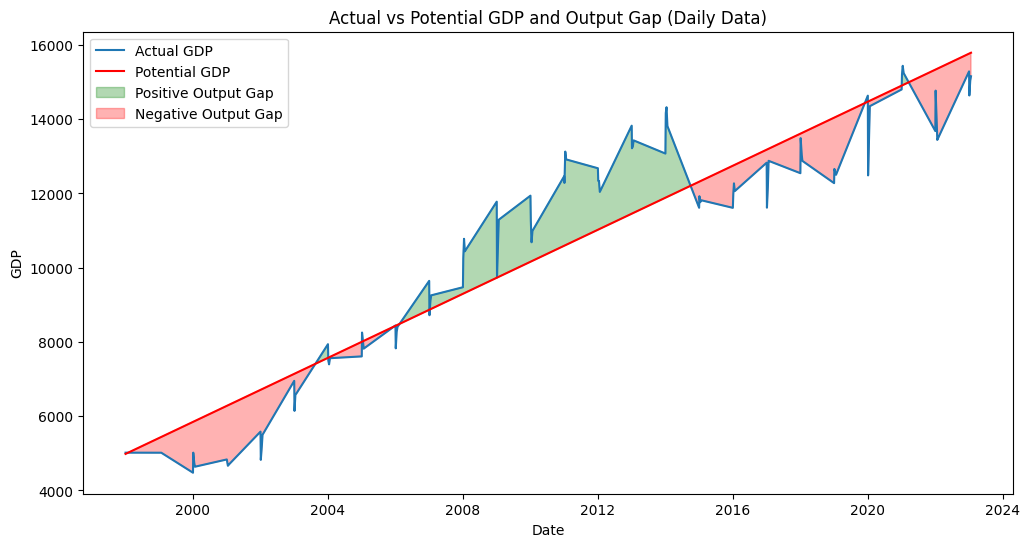

In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Load and preprocess the data
df_gdp_llevel = pd.read_excel('Q GDP LEVEL.xlsx')
df_gdp_llevel['Date'] = df_gdp_llevel['Date'].apply(parse_quarter)
df_gdp_llevel['Date'] = pd.to_datetime(df_gdp_llevel['Date'], format='%Y-%d-%m')
df_gdp_llevel = df_gdp_llevel.set_index('Date')
df_gdp_llevel_daily = df_gdp_llevel['GDPL'].resample('D').mean()
df_gdp_llevel_daily_interpolated = df_gdp_llevel_daily.interpolate(method='linear')

# Fit a linear model to the daily interpolated data
model = LinearRegression()
X = np.arange(len(df_gdp_llevel_daily_interpolated)).reshape(-1, 1)  # Time as a feature
y = df_gdp_llevel_daily_interpolated.values  # GDP values
model.fit(X, y)

# Predict potential GDP on the daily data
potential_gdp_daily = model.predict(X)

# Calculate daily output gap
output_gap_daily = y - potential_gdp_daily

# Create a DataFrame for the results
df_results = pd.DataFrame({
    'Actual GDP': df_gdp_llevel_daily_interpolated,
    'Potential GDP': potential_gdp_daily,
    'Output Gap': output_gap_daily
}, index=df_gdp_llevel_daily_interpolated.index)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_results.index, df_results['Actual GDP'], label='Actual GDP')
plt.plot(df_results.index, df_results['Potential GDP'], label='Potential GDP', color='red')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] > df_results['Potential GDP']), 
                 color='green', alpha=0.3, label='Positive Output Gap')
plt.fill_between(df_results.index, df_results['Actual GDP'], df_results['Potential GDP'], 
                 where=(df_results['Actual GDP'] <= df_results['Potential GDP']), 
                 color='red', alpha=0.3, label='Negative Output Gap')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Actual vs Potential GDP and Output Gap (Daily Data)')
plt.legend()
plt.show()


In [137]:
df_gdp_llevel_daily_interpolated

Date
1998-01-04     5018.907700
1998-01-05     5018.907700
1998-01-06     5018.907700
1998-01-07     5018.907700
1998-01-08     5018.907700
                  ...     
2023-01-21    15098.451328
2023-01-22    15113.028394
2023-01-23    15127.605459
2023-01-24    15142.182525
2023-01-25    15156.759591
Freq: D, Name: GDPL, Length: 9153, dtype: float64

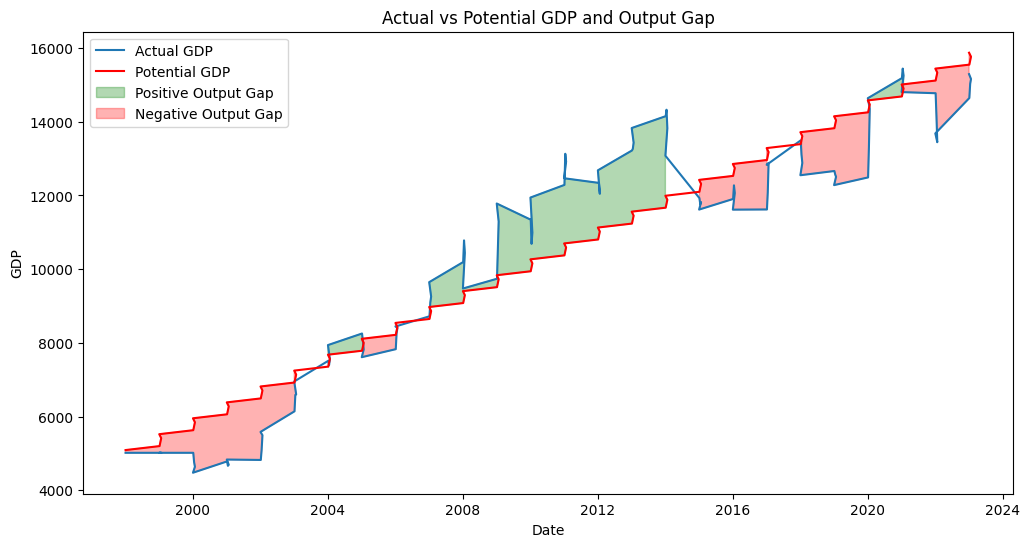

In [89]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming df_gdp_llevel is already defined and has the GDPL column

# Fit a linear model to estimate potential GDP
model = LinearRegression()
X = np.arange(len(df_gdp_llevel)).reshape(-1, 1)  # Time as a feature

# Ensure y is a one-dimensional array for GDP values
y = df_gdp_llevel['GDPL'].values  
model.fit(X, y)

# Predict potential GDP
potential_gdp = model.predict(X)

# Calculate output gap
output_gap = y - potential_gdp

# Add to DataFrame
df_gdp_llevel['Potential GDP'] = potential_gdp
df_gdp_llevel['Output Gap'] = output_gap

# Plotting for visualization
plt.figure(figsize=(12, 6))
plt.plot(df_gdp_llevel.index, df_gdp_llevel['GDPL'], label='Actual GDP')
plt.plot(df_gdp_llevel.index, df_gdp_llevel['Potential GDP'], label='Potential GDP', color='red')
plt.fill_between(df_gdp_llevel.index, df_gdp_llevel['GDPL'], df_gdp_llevel['Potential GDP'], 
                 where=(df_gdp_llevel['GDPL'] > df_gdp_llevel['Potential GDP']), 
                 color='green', alpha=0.3, label='Positive Output Gap')
plt.fill_between(df_gdp_llevel.index, df_gdp_llevel['GDPL'], df_gdp_llevel['Potential GDP'], 
                 where=(df_gdp_llevel['GDPL'] <= df_gdp_llevel['Potential GDP']), 
                 color='red', alpha=0.3, label='Negative Output Gap')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.title('Actual vs Potential GDP and Output Gap')
plt.legend()
plt.show()


In [131]:
df_gdp_llevel

,GDPL,Potential GDP,Output Gap
Date,,,
2023-01-04,15289.098679,15869.579526,-580.480846
2023-01-25,15156.759591,15761.814546,-605.054955
2023-01-16,15025.566000,15654.049566,-628.483566
2023-01-07,14640.675000,15546.284587,-905.609587
2022-01-04,13680.895000,15438.519607,-1757.624607
...,...,...,...
1999-01-04,5018.907700,5524.141479,-505.233779
1999-01-25,5018.907700,5416.376500,-397.468800
1999-01-16,5018.907700,5308.611520,-289.703820


In [116]:
df_gdp_llevel.index.unique()

DatetimeIndex(['2023-01-04', '2023-01-25', '2023-01-16', '2023-01-07',
               '2022-01-04', '2022-01-25', '2022-01-16', '2022-01-07',
               '2021-01-04', '2021-01-25',
               ...
               '2001-01-07', '2000-01-04', '2000-01-25', '2000-01-16',
               '2000-01-07', '1999-01-04', '1999-01-25', '1999-01-16',
               '1999-01-07', '1998-01-04'],
              dtype='datetime64[ns]', name='Date', length=101, freq=None)

In [48]:
df_gdp_llevel

,GDPL,Potential GDP,Output Gap
Date,,,
2023-01-04,15289.098679,14562.187054,726.911625
2023-01-25,15156.759591,14505.806946,650.952644
2023-01-16,15025.566000,14449.426838,576.139162
2023-01-07,14640.675000,14393.046730,247.628270
2022-01-04,13680.895000,14336.666622,-655.771622
...,...,...,...
2009-01-04,11779.932000,11404.900994,375.031006
2009-01-25,11291.420000,11348.520886,-57.100886
2009-01-16,10523.515000,11292.140777,-768.625777


import pandas as pd

# Function to convert quarter format to datetime
def parse_quarter(string):
    year, quarter = string.split('-')
    month = (int(quarter[1]) - 1) * 3 + 1  # Convert quarter to start month
    return f'{year}-{month:02d}-01'  # Return the first day of the start month

df_ogap = pd.read_csv('Q GDP.csv')
df_ogap = df_ogap.rename(columns={'TIME': 'Date'})
df_ogap['Date'] = df_ogap['Date'].apply(parse_quarter)  # Apply custom parsing function
df_ogap['Date'] = pd.to_datetime(df_ogap['Date'])  # Convert to datetime
df_ogap = df_ogap.set_index('Date')
df_ogap_daily = df_ogap['Gdp growth'].resample('D').mean()
df_ogap_daily = pd.DataFrame(df_ogap_daily.interpolate())



df_ogap_daily=df_ogap_daily.sort_values(by='Date')
# convert to YYYY-MM
df_ogap_daily.index = pd.to_datetime(df_ogap_daily.index, format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')
df_ogap_daily.Date = df_ogap_daily.Date.apply(lambda x: str(x).replace(x, x+'-01'))
df_ogap_daily['Date'] = df_ogap_daily['Date'].astype('datetime64[ns]')

In [138]:
df_results

,Actual GDP,Potential GDP,Output Gap
Date,,,
1998-01-04,5018.907700,4985.658849,33.248851
1998-01-05,5018.907700,4986.839613,32.068087
1998-01-06,5018.907700,4988.020377,30.887323
1998-01-07,5018.907700,4989.201140,29.706560
1998-01-08,5018.907700,4990.381904,28.525796
...,...,...,...
2023-01-21,15098.451328,15787.284155,-688.832827
2023-01-22,15113.028394,15788.464918,-675.436525
2023-01-23,15127.605459,15789.645682,-662.040222


In [139]:
df_ogap_daily =df_results['Output Gap']


In [130]:
df_not_clean.Date

0      1998-12-01
1      1998-12-02
2      1998-12-03
3      1998-12-04
4      1998-12-05
          ...    
8701   2022-09-27
8702   2022-09-28
8703   2022-09-29
8704   2022-09-30
8705   2022-10-01
Name: Date, Length: 8706, dtype: datetime64[ns]

# Merging all datasets 

In [93]:
 
## Convert monthly to daily for mro
from datetime import datetime
#import monthly and cleaning date columns
df_mro = pd.read_excel('Inflation & interest.xlsx')
df_mro = df_mro.rename(columns={'Unnamed: 0':'Date'})
# Convert the 'Date' column to a datetime format

# Append a default day to each date string and then convert to datetime
df_mro['Date'] = pd.to_datetime(df_mro['Date'].apply(lambda x: str(x) + '-01'), format='%m/%Y-%d')

# Set the 'Date' column as the index
df_mro = df_mro.set_index('Date')

# Resample and interpolate
df_mro_daily = df_mro.resample('D').mean()
df_mro_daily = df_mro_daily.interpolate()

# Reset the index and keep 'Date' as a column


df_mro['Rate'] = df_mro['LTR INT RATE'].astype(float)

#Interpolation to get daily MRO


In [39]:
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [112]:
df_ogap_daily

,Date,GDPL


In [110]:
df_ogap_daily=pd.DataFrame(df_ogap_daily, columns=['Date', 'GDPL'])

In [111]:
df_ogap_daily

,Date,GDPL


In [153]:
## Create date column and convert it to dataframe
from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

date_ = []
start_dt = date(1998, 12, 1)
end_dt = date(2022, 10, 1)
for dt in daterange(start_dt, end_dt):
    date_.append(dt.strftime("%Y-%m-%d"))
df_date = pd.DataFrame(date_, columns=['Date'])
df_date['Date'] = df_date['Date'].astype('datetime64[ns]')

In [141]:
df_mro_daily=df_mro_daily
df_mro_daily

,Inflation,LTR INT RATE
Date,,
1998-12-01,1.358338,4.278732
1998-12-02,1.351708,4.276394
1998-12-03,1.345077,4.274057
1998-12-04,1.338446,4.271719
1998-12-05,1.331816,4.269382
...,...,...
2023-08-28,5.476246,3.394072
2023-08-29,5.459918,3.395730
2023-08-30,5.443590,3.397387


In [152]:
df_date['Date']=

dtype('O')

In [154]:
import warnings
warnings.filterwarnings("ignore")

## join date col & reg_df
df_not_clean = pd.merge(df_date,df_eurostock_final,how='left',on=['Date'])
df_not_clean_2 = pd.merge(df_not_clean,df_ogap_daily,how='left',on=['Date'])
df_not_clean_3 = pd.merge(df_not_clean_2,df_mro_daily,how='left',on=['Date'])

df_conf.rename(columns={'date':'Date'}, inplace=True)
df_conf['Date'] = df_conf['Date'].astype('datetime64[ns]')

df_final_not_clean = pd.merge(df_not_clean_3,df_conf,how='left',on=['Date'])

df_final_not_clean.set_index('Date', inplace=True)
df_final_not_clean.dropna(axis = 0, how = 'all', inplace = True)
df_final_not_clean.reset_index(inplace=True)

# Interpolate our variables with a daily granularity
df_final_not_clean.HICP = df_final_not_clean['Inflation'].interpolate()
df_final_not_clean.output_gap = df_final_not_clean['Output Gap'].interpolate()
df_final_not_clean.mro = df_final_not_clean['LTR INT RATE'].interpolate()

df_final_not_clean.dropna(subset= ['link'], inplace=True)

#df_final_not_clean = df_final_not_clean [['Date','jaccard_similarity','pessimism','pessimism_2','eurostock_cumulate','eurostock_abnormal_return', 'eurostock_CAR', 'Inflation', 'Gdp growth', 'mro', 'diff']]
df_final_not_clean = df_final_not_clean [['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Output Gap', 'LTR INT RATE',

       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff']]
df_final_not_clean.drop_duplicates(subset=['jaccard_similarity','diff'], inplace=True)

#Calculating MRO returns
df_final_not_clean['change_MRO_Rate'] = df_final_not_clean['LTR INT RATE'].diff(1)

#Calculating log for similarity and for Time variable (log_diff)
df_final_not_clean['log_similarity'] = np.log(df_final_not_clean['jaccard_similarity'])
df_final_not_clean['log_diff'] = np.log(df_final_not_clean['diff'].values)

# filling in the remaining missing data w/ latest value
df_final_not_clean.eurostock_cumulate.ffill(inplace=True)
df_final_not_clean.eurostock_abnormal_return.ffill(inplace=True)
df_final_not_clean.eurostock_CAR.ffill(inplace=True)


df_final_not_clean.reset_index(inplace=True, drop=True)
df_final_not_clean = df_final_not_clean[df_final_not_clean.Date > '1998-12-31']
df_final_not_clean

,Date,eurostock_cumulate,eurostock_abnormal_return,eurostock_CAR,Inflation,Output Gap,LTR INT RATE,jaccard_similarity,pessimism,pessimism_2,date_2,diff,change_MRO_Rate,log_similarity,log_diff
2,1999-01-07,0.000444,-0.016597,-0.025643,1.113005,-401.272150,4.192241,0.088464,0.000000,0.000000,1999-01-07,212.0,-0.037401,-2.425165,5.356586
3,1999-02-04,0.000563,-0.001802,-0.033480,0.927347,-450.037932,4.126789,0.120927,0.428571,0.019455,1999-02-04,240.0,-0.065452,-2.112569,5.480639
4,1999-03-04,0.000270,0.011865,-0.018795,0.768440,-527.071635,4.078243,0.015087,0.622047,0.048796,1999-03-04,268.0,-0.048546,-4.193907,5.590987
5,1999-04-08,-0.000043,0.000567,0.039784,0.848463,-623.363765,4.193665,0.012000,0.166667,0.006462,1999-04-08,303.0,0.115423,-4.422849,5.713733
6,1999-05-06,0.000121,-0.003924,-0.017575,0.912481,-700.397469,4.286003,0.086957,0.142857,0.005445,1999-05-06,331.0,0.092338,-2.442347,5.802118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,2022-02-03,0.000704,-0.017093,0.026775,5.557810,-1880.570522,0.850164,0.155854,0.225806,0.010014,2022-02-03,8640.0,0.299891,-1.858837,9.064158
257,2022-03-10,0.000605,-0.028864,0.017972,6.177716,-1734.045057,1.121812,0.150238,0.471698,0.024390,2022-03-10,8675.0,0.271648,-1.895531,9.068201
258,2022-07-01,-0.000242,0.001715,0.008822,8.565063,-1260.977125,2.256298,0.106563,0.368421,0.021000,2022-07-01,8788.0,1.134486,-2.239022,9.081142
259,2022-07-21,-0.000642,0.004151,0.038718,8.849845,-1177.248287,2.320819,0.154290,0.294118,0.017564,2022-07-21,8808.0,0.064520,-1.868922,9.083416


Date
2023-01-04    -580.480846
2023-01-25    -605.054955
2023-01-16    -628.483566
2023-01-07    -905.609587
2022-01-04   -1757.624607
                 ...     
1999-01-04    -505.233779
1999-01-25    -397.468800
1999-01-16    -289.703820
1999-01-07    -181.938841
1998-01-04     -74.173861
Name: Output Gap, Length: 101, dtype: float64

In [97]:
df_final_not_clean.isna().sum()

Date                           0
eurostock_cumulate             0
eurostock_abnormal_return      0
eurostock_CAR                  0
Inflation                      0
Output Gap                   257
LTR INT RATE                   0
jaccard_similarity             0
pessimism                      0
pessimism_2                    0
date_2                         0
diff                           0
change_MRO_Rate                0
log_similarity                 0
log_diff                       0
dtype: int64

In [45]:
df_final_not_clean.columns

Index(['Date', 'eurostock_cumulate', 'eurostock_abnormal_return',
       'eurostock_CAR', 'Inflation', 'Gdp growth', 'LTR INT RATE',
       'jaccard_similarity', 'pessimism', 'pessimism_2', 'date_2', 'diff',
       'change_MRO_Rate', 'log_similarity', 'log_diff'],
      dtype='object')

# Regression part of original paper (replication of results)

In [95]:
pip install Stargazer

In [156]:
 
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

#Creating a new df with replicate data
df_replicate = df_final_not_clean[df_final_not_clean['Date'] <='2013-12-31']

#exlude first row to avoid na
df_replicate = df_replicate.iloc[2:]

# fit linear regression
def fit_linear_regression(y,x):
    # Add a constant to the predictor variables
    x = sm.add_constant(x)

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# REPLICATING REGRESSION RESULTS OF TABLE 3 (in original paper)


In [157]:

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate['log_diff'].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['log_diff', 'Output Gap', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['log_similarity'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())


#calculating CAR absolute value
df_replicate['CAR_abs'] = df_replicate['eurostock_CAR'].abs()
#calculating interaction
df_replicate['interaction'] = df_replicate['pessimism_2'] * df_replicate['jaccard_similarity']

# We didn't include the Time (count) variable below

# REPLICATING REGRESSION RESULTS OF TABLE 4 (in original paper)

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['pessimism_2']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction']].dropna())

fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())
fit_linear_regression(df_replicate['CAR_abs'].dropna(), df_replicate[['interaction', 'Output Gap', 'Inflation', 'pessimism_2']].dropna())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     32.54
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           8.41e-17
Time:                        01:05:32   Log-Likelihood:                -222.77
No. Observations:                 181   AIC:                             453.5
Df Residuals:                     177   BIC:                             466.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.2200      0.190    -

# Extension part of original paper  


In [158]:
 
df_final = df_final_not_clean.iloc[2:]
 

# Get the last row
last_row = df_final.tail(1)

# Drop the last row
df_final = df_final.drop(last_row.index)

# EXTENDING REGRESSION RESULTS OF TABLE 3

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final['log_diff'].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff']].dropna())

fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['Inflation']].dropna())


                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     12.42
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           1.33e-07
Time:                        01:07:01   Log-Likelihood:                -360.80
No. Observations:                 256   AIC:                             729.6
Df Residuals:                     252   BIC:                             743.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.4571      0.128    -

# EXTENDING REGRESSION RESULTS OF TABLE 4



In [159]:
#calculating CAR absolute value
df_final['CAR_abs'] = df_final['eurostock_CAR'].abs()
#calculating interaction
df_final['interaction'] = df_final['pessimism_2'] * df_final['jaccard_similarity'] 

# EXTENDING REGRESSION RESULTS OF TABLE 4
print('m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m1 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['pessimism_2']].dropna())
print('m2 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m2 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())
print('m3 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction']].dropna())
print('m4 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap', 'Inflation', 'change_MRO_Rate']].dropna())
print('m5 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------')
m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap', 'Inflation', 'pessimism_2']].dropna())


m1 ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                CAR_abs   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.828
Date:                Wed, 03 Jan 2024   Prob (F-statistic):             0.0515
Time:                        01:07:36   Log-Likelihood:                 497.23
No. Observations:                 256   AIC:                            -990.5
Df Residuals:                     254   BIC:                            -983.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
     

# *****************************SUMMARY STATISTICS*****************************


In [160]:

def summarize_dataframe(df):
    summary = df.describe().T
    summary = summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
    return summary

summary = summarize_dataframe(df_final)
summary

,mean,std,min,25%,50%,75%,max
eurostock_cumulate,0.000034,0.000954,-0.003436,-0.000501,0.000210,0.000682,0.001922
eurostock_abnormal_return,-0.001023,0.017253,-0.134585,-0.007283,0.000685,0.007385,0.055791
eurostock_CAR,0.001903,0.047514,-0.355354,-0.016593,0.006512,0.026864,0.113426
Inflation,1.949590,1.191715,-0.128216,1.277753,2.039145,2.459526,8.849845
Output Gap,112.133493,1124.743254,-1880.570522,-783.166599,-109.387963,1236.953077,2295.613590
LTR INT RATE,3.369399,1.639145,-0.012688,1.825272,4.006483,4.458785,5.655755
jaccard_similarity,0.256707,0.157248,0.004296,0.119163,0.260118,0.377816,0.612813
pessimism,-0.062060,0.287652,-0.724138,-0.280000,-0.058824,0.135135,0.755656
pessimism_2,-0.002555,0.015823,-0.042453,-0.013726,-0.003197,0.006938,0.048796
diff,4188.140625,2381.570909,268.000000,2149.250000,4058.500000,5985.750000,8808.000000


# Capture non-linearity

In [161]:
  
def square_column(df, col):
    df['square_' + col] = df[col] ** 2

#apply var² on Time var (diff)
square_column(df_final, 'diff')

# after ² we apply log
df_final['log_square_diff'] = np.log(df_final['square_diff'])

#apply var² to Similarity
square_column(df_final, 'jaccard_similarity')

#apply var² to INFLATION
square_column(df_final, 'Inflation')
 
def fit_linear_regression_nc(y,x):

    # Fit a linear regression model
    model = sm.OLS(y, x).fit()

    # View the model summary
    print(model.summary())

    return model

# CAPTURING NON-LINEARITY ON SIMILARITY & INFLATION


In [162]:
m1 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['log_diff', 'log_square_diff']].dropna())

m2 = fit_linear_regression(df_final['log_similarity'].dropna(), df_final[['square_Inflation', 'Inflation']].dropna())

                            OLS Regression Results                            
Dep. Variable:         log_similarity   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     103.5
Date:                Wed, 03 Jan 2024   Prob (F-statistic):           1.28e-20
Time:                        01:08:01   Log-Likelihood:                -334.68
No. Observations:                 256   AIC:                             673.4
Df Residuals:                     254   BIC:                             680.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.6632      0.588    -

# CAPTURING NON-LINEARITY ON 


In [163]:



m1 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['jaccard_similarity', 'square_jaccard_similarity']].dropna())
# w/o constant
m2 = fit_linear_regression_nc(df_final['CAR_abs'].dropna(), df_final[['interaction',  'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m3 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())
m4 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction',  'Output Gap', 'jaccard_similarity', 'square_jaccard_similarity']].dropna())

m5 = fit_linear_regression(df_final['CAR_abs'].dropna(), df_final[['interaction', 'Output Gap']].dropna())

                                 OLS Regression Results                                
Dep. Variable:                CAR_abs   R-squared (uncentered):                   0.413
Model:                            OLS   Adj. R-squared (uncentered):              0.408
Method:                 Least Squares   F-statistic:                              89.26
Date:                Wed, 03 Jan 2024   Prob (F-statistic):                    4.38e-30
Time:                        01:08:20   Log-Likelihood:                          485.14
No. Observations:                 256   AIC:                                     -966.3
Df Residuals:                     254   BIC:                                     -959.2
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------